In [1]:
import os
import pandas as pd 
import numpy as np 
import tensorflow as tf
import keras
from keras.preprocessing.image import load_img, img_to_array
from keras import layers
import matplotlib.pyplot as plt
import json
import shutil
from sklearn.preprocessing import OneHotEncoder

# LOADING DATASET

In [2]:
class DataLoader:
    def __init__(self, base_dir, labels_dir, batch_size, target_size=(224, 224)):
        self.base_dir = base_dir
        self.labels_dir = labels_dir
        self.batch_size = batch_size
        self.target_size = target_size

        # Updated label sizes to include verbs
        self.label_sizes = {
            'instrument': 7,  # 0-5 original classes, 6 for -1
            'triplet': 101
        }

        # Cache for annotations
        self.annotation_cache = {}

        self.rotation_layer = tf.keras.layers.RandomRotation(
            factor=0.2,  # This means [-0.2, 0.2] radians
            fill_mode='nearest'
        )

    def _apply_augmentation(self, image):
        """Apply random augmentations to the image"""
        # Ensure input is float32
        image = tf.cast(image, tf.float32)
        
        # Random brightness
        image = tf.image.random_brightness(image, 0.2)
        
        # Random contrast
        image = tf.image.random_contrast(image, 0.8, 1.2)
        
        # Random flip left-right
        image = tf.image.random_flip_left_right(image)
        
        # Random rotation using the pre-initialized layer
        image = self.rotation_layer(image)
        
        # Random zoom
        # Convert to 4D tensor for zoom operation
        image_4d = tf.expand_dims(image, 0)
        
        # Apply random zoom
        zoom_factor = tf.random.uniform([], 0.8, 1.2)
        scaled_size = tf.cast(
            tf.cast(self.target_size, tf.float32) * zoom_factor,
            tf.int32
        )
        
        # Resize with zoom factor
        image_zoomed = tf.image.resize(
            image_4d,
            scaled_size,
            method=tf.image.ResizeMethod.BILINEAR
        )
        
        # Crop or pad to target size
        image_processed = tf.image.resize_with_crop_or_pad(
            image_zoomed,
            self.target_size[0],
            self.target_size[1]
        )
        
        # Remove the extra dimension we added
        image = tf.squeeze(image_processed, 0)
        
        # Ensure values are in [0, 1]
        image = tf.clip_by_value(image, 0, 1)
        
        return image

    @staticmethod
    def clear_cache_directory(cache_dir):
        if cache_dir and os.path.exists(cache_dir):
            shutil.rmtree(cache_dir)
        if cache_dir:
            os.makedirs(cache_dir, exist_ok=True)
        lock_files = glob.glob(os.path.join(os.path.dirname(cache_dir) if cache_dir else ".", "*.lockfile"))
        for lock_file in lock_files:
            try:
                os.remove(lock_file)
            except OSError:
                pass

    def _get_dataset_files(self):
        image_paths = []
        json_paths = []
        keys = []

        for video_folder in tf.io.gfile.listdir(self.base_dir):
            video_path = os.path.join(self.base_dir, video_folder)
            if not tf.io.gfile.isdir(video_path):
                continue

            json_path = os.path.join(self.labels_dir, f'{video_folder}.json')
            if not tf.io.gfile.exists(json_path):
                print(f"Warning: No JSON file found for {video_folder}")
                continue

            try:
                with tf.io.gfile.GFile(json_path, 'r') as f:
                    annotations = json.load(f)["annotations"]
            except Exception as e:
                print(f"Warning: Error loading JSON for {video_folder}: {str(e)}")
                continue

            for img_file in sorted(tf.io.gfile.listdir(video_path)):
                if not img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
                    continue

                try:
                    key = str(int(img_file.split('.')[0]))
                    if key not in annotations:
                        print(f"Warning: No annotation found for {img_file} in {video_folder}")
                        continue

                    ann_lists = annotations[key]

                    img_path = os.path.join(video_path, img_file)
                    image_paths.append(img_path)
                    json_paths.append(json_path)
                    keys.append(key)

                except ValueError:
                    print(f"Warning: Invalid image filename format: {img_file}")
                    continue

        if not image_paths:
            raise ValueError("No valid image-annotation pairs found in the dataset")

        print(f"Found {len(image_paths)} valid image-annotation pairs")
        return image_paths, json_paths, keys

    def _load_and_cache_annotations(self, json_path):
        if isinstance(json_path, tf.Tensor):
            json_path = json_path.numpy().decode('utf-8')

        if json_path not in self.annotation_cache:
            with tf.io.gfile.GFile(json_path, 'r') as f:
                self.annotation_cache[json_path] = json.load(f)["annotations"]
        return self.annotation_cache[json_path]

    def _process_annotations(self, json_path, key):
        try:
            if isinstance(key, tf.Tensor):
                key = key.numpy().decode('utf-8')

            annotations = self._load_and_cache_annotations(json_path)
            key_str = str(key)

            if key_str not in annotations:
                raise KeyError(f"Key {key_str} not found in annotations")

            annotation_data = annotations[key_str]
            if not isinstance(annotation_data, list):
                annotation_data = [annotation_data]

            # Process all indices
            instrument_indices = [6 if ann[1] == -1 else ann[1] for ann in annotation_data]
            triplet_indices = [100 if ann[0] == -1 else ann[0] for ann in annotation_data]

            # Create one-hot vectors
            instrument_vector = np.zeros(self.label_sizes['instrument'], dtype=np.float32)
            triplet_vector = np.zeros(self.label_sizes['triplet'], dtype=np.float32)

            # Set 1 for present indices
            for idx in instrument_indices:
                instrument_vector[idx] = 1
            for idx in instrument_indices:
                triplet_vector[idx] = 1

            return [
                instrument_vector,
                triplet_vector
            ]

        except Exception as e:
            print(f"Error processing annotations: {str(e)}")
            print(f"JSON Path: {json_path}")
            print(f"Key: {key}")
            raise

    def _parse_image(self, img_path, training=True):
        img = tf.io.read_file(img_path)
        img = tf.image.decode_png(img, channels=3)
        img = tf.image.resize(img, self.target_size)
        img = tf.cast(img, tf.float32) / 255.0
        
        if training:
            img = self._apply_augmentation(img)
        
        return img

    @tf.function
    def _process_data(self, img_path, json_path, key, training=True):
        img = self._parse_image(img_path, training)
        annotations = tf.py_function(
            self._process_annotations,
            [json_path, key],
            [tf.float32, tf.float32]  # Added verb vector type
        )

        # Set shapes for all vectors
        annotations[0].set_shape([self.label_sizes['instrument']]) 
        annotations[1].set_shape([self.label_sizes['triplet']])

        return img, (annotations[0], annotations[1])

    def create_datasets(self, cache_dir=None, train_split=0.85):
        if cache_dir:
            self.clear_cache_directory(cache_dir)

        image_paths, json_paths, keys = self._get_dataset_files()
        total_size = len(image_paths)
        train_size = int(total_size * train_split)

        indices = np.arange(total_size)
        np.random.shuffle(indices)

        train_indices = indices[:train_size]
        val_indices = indices[train_size:]

        def create_subset(indices, training=True):
            subset_images = [image_paths[i] for i in indices]
            subset_jsons = [json_paths[i] for i in indices]
            subset_keys = [keys[i] for i in indices]

            dataset = tf.data.Dataset.from_tensor_slices(
                (subset_images, subset_jsons, subset_keys)
            )

            dataset = dataset.map(
                lambda x, y, z: self._process_data(x, y, z, training),
                num_parallel_calls=tf.data.AUTOTUNE
            )

            if cache_dir:
                dataset = dataset.cache()

            if training:
                dataset = dataset.shuffle(buffer_size=min(len(indices), 1000))

            return dataset.batch(
                self.batch_size
            ).prefetch(
                tf.data.AUTOTUNE
            )

        train_dataset = create_subset(train_indices, training=True)
        val_dataset = create_subset(val_indices, training=False)

        print(f"Total dataset size: {total_size}")
        print(f"Training set size: {len(train_indices)}")
        print(f"Validation set size: {len(val_indices)}")

        return train_dataset, val_dataset

# Helper function
def create_split_datasets(base_dir, labels_dir, batch_size, cache_dir=None):
    loader = DataLoader(base_dir, labels_dir, batch_size=batch_size)
    return loader.create_datasets(cache_dir=cache_dir)

base_dir = '/kaggle/input/bh-dataset/CholecT50/videos'
labels_dir = '/kaggle/input/bh-dataset/CholecT50/labels'
batch_size = 64

train_dataset, val_dataset = create_split_datasets(base_dir, labels_dir, batch_size)

Found 17648 valid image-annotation pairs
Total dataset size: 17648
Training set size: 15000
Validation set size: 2648


# ULSAM MODEL

In [3]:
class ULSAMLayer(layers.Layer):
    def __init__(self, groups=8, **kwargs):
        super(ULSAMLayer, self).__init__(**kwargs)
        self.groups = groups
        
        # Define layers outside of the call method to prevent re-creation in tf.function
        self.depthwise_conv = layers.DepthwiseConv2D(kernel_size=1, strides=1, padding='same')
        self.max_pool = layers.MaxPooling2D(pool_size=3, strides=1, padding='same')
        self.conv = layers.Conv2D(filters=80, kernel_size=1, strides=1, padding='same')  # Assuming group_size is 80

    def call(self, input_tensor):
        # Grouping the channels for ULSAM
        channels = input_tensor.shape[-1]
        group_size = channels // self.groups

        # Splitting the channels into groups
        splits = tf.split(input_tensor, num_or_size_splits=self.groups, axis=-1)

        # Process each split independently
        output_splits = []
        for split in splits:
            processed_split = self.process_split(split, group_size)
            output_splits.append(processed_split)

        # Concatenating the processed splits
        return tf.concat(output_splits, axis=-1)

    def process_split(self, split, group_size):
        # Applying DepthwiseConv2D, MaxPooling2D, and Conv2D
        x = self.depthwise_conv(split)
        x = self.max_pool(x)
        x = self.conv(x)
        return x


# IRB for MV2

In [4]:
def inverted_residual_block(input_tensor, filters, stride, expansion):
    input_filters = input_tensor.shape[-1]
    expanded_filters = input_filters * expansion

    # Expansion phase
    if expansion != 1:
        x = layers.Conv2D(expanded_filters, kernel_size=1, padding='same', use_bias=False)(input_tensor)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU(6.)(x)
    else:
        x = input_tensor

    # Depthwise convolution
    x = layers.DepthwiseConv2D(kernel_size=3, strides=stride, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU(6.)(x)

    # Pointwise convolution
    x = layers.Conv2D(filters, kernel_size=1, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)

    # Add residual connection if input and output shapes match
    if stride == 1 and input_filters == filters:
        x = layers.Add()([x, input_tensor])
    return x

# Combination of MV2 and ULSAM 

In [5]:
def MV2_ulsam():
    inputs = layers.Input(shape=(224, 224, 3))
    x = layers.Conv2D(32, kernel_size=3, strides=2, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU(6.)(x)

    # Inverted residual blocks
    x = inverted_residual_block(x, filters=16, stride=1, expansion=1)

    # Sequence of blocks following MobileNetV2's structure
    block_specs = [
        (24, 2, 6), (24, 1, 6), (32, 2, 6), (32, 1, 6), (32, 1, 6),
        (64, 2, 6), (64, 1, 6), (64, 1, 6), (64, 1, 6), (96, 1, 6),
        (96, 1, 6), (96, 1, 6), (160, 2, 6), (160, 1, 6), (160, 1, 6),
        (320, 1, 6)
    ]

    for i, (filters, stride, expansion) in enumerate(block_specs):
        x = inverted_residual_block(x, filters=filters, stride=stride, expansion=expansion)
        if i==13 or i==14:
            x = ULSAMLayer()(x)  # Apply ULSAM after every block


    x= layers.Conv2D(1280, kernel_size=1, padding='same')(x)
    x= layers.BatchNormalization()(x)
    x= layers.ReLU(6.)(x)
    x=layers.Flatten()(x)

    #branch1 for instruments
    Dense1=layers.Dense(512, activation='relu',)(x)
    Output1=layers.Dense(units=7,activation='sigmoid',name='instrument_output')(Dense1)
    
    #branch2 for triplet
    Dense2=layers.Dense(1024, activation='relu')(x)
    Output2=layers.Dense(units=101,activation='sigmoid',name="triplet_output")(Dense2)
    
    return keras.Model(
        inputs=inputs,
        outputs=[Output1,Output2]
    )


# COMPILING AND TRAINING 

In [6]:
model = MV2_ulsam()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-8),
    loss={
        'instrument_output': keras.losses.BinaryCrossentropy(),   
        'triplet_output': keras.losses.BinaryCrossentropy()
    },
    metrics={
        'instrument_output': ['accuracy'],
        'triplet_output': ['accuracy'],
    }
)

# # Train the model with the custom callback
with tf.device('/GPU:0'):
    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=100,
        callbacks=[
            keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
            keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=1e-12),
        ]
    )

Epoch 1/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 416s 1s/step - instrument_output_accuracy: 0.0849 - loss: 1.7230 - triplet_output_accuracy: 0.0017 - val_instrument_output_accuracy: 0.0223 - val_loss: 1.4123 - val_triplet_output_accuracy: 0.0000e+00 - learning_rate: 1.0000e-08
Epoch 2/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 124s 505ms/step - instrument_output_accuracy: 0.1325 - loss: 1.5667 - triplet_output_accuracy: 0.0024 - val_instrument_output_accuracy: 0.0223 - val_loss: 1.3699 - val_triplet_output_accuracy: 0.0000e+00 - learning_rate: 1.0000e-08
Epoch 3/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 125s 509ms/step - instrument_output_accuracy: 0.1877 - loss: 1.4304 - triplet_output_accuracy: 0.0032 - val_instrument_output_accuracy: 0.4807 - val_loss: 1.3194 - val_triplet_output_accuracy: 3.7764e-04 - learning_rate: 1.0000e-08
Epoch 4/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 141s 505ms/step - instrument_output_accuracy: 0.2638 - loss: 1.3151 - triplet_output_accuracy: 0.0069 - val_instrument_output_accuracy: 0.2621 

In [7]:
# Save the final model to a file
model.save('model.h5')

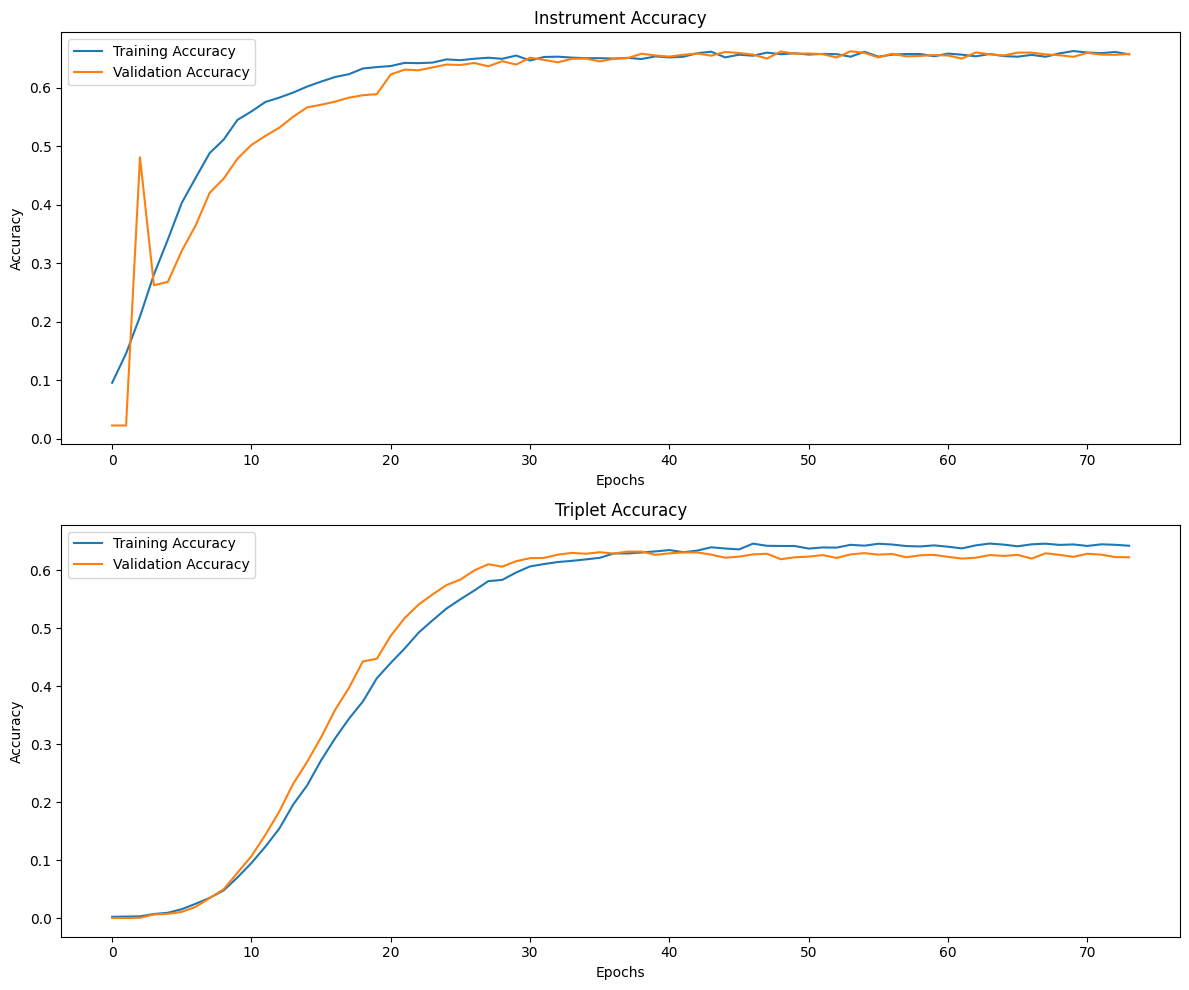

In [8]:
import matplotlib.pyplot as plt

# Extracting the accuracies for each output
instrument_train_accuracy = history.history['instrument_output_accuracy']
triplet_train_accuracy = history.history['triplet_output_accuracy']

instrument_val_accuracy = history.history['val_instrument_output_accuracy']
triplet_val_accuracy = history.history['val_triplet_output_accuracy']

# Plotting the accuracies
plt.figure(figsize=(12, 10))

# Instrument Accuracy
plt.subplot(2, 1, 1)
plt.plot(instrument_train_accuracy, label='Training Accuracy')
plt.plot(instrument_val_accuracy, label='Validation Accuracy')
plt.title('Instrument Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


# triplet Accuracy
plt.subplot(2, 1,2)
plt.plot(triplet_train_accuracy, label='Training Accuracy')
plt.plot(triplet_val_accuracy, label='Validation Accuracy')
plt.title('Triplet Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
